In [1]:
# Required Libraries
%pip install -q qiskit[visualization]
%pip install -q qiskit_aer
%pip install -q qiskit_ibm_runtime
%pip install -q matplotlib

zsh:1: no matches found: qiskit[visualization]
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## BBM92 Protocol

In [2]:
import math
import numpy as np
import random
import re
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

from qiskit_aer import AerSimulator

## Simulation Without the Presence of an Eavesdropper

### Step 1: creating the singlets

In the first step Alice and Bob receive their qubits of the singlet states $\lvert\psi_s\rangle$ created by Charlie.

For our simulation, we need registers with two quantum bits and four classical bits.

In [3]:
# Creating registers
qr = QuantumRegister(2, name="qr")
cr = ClassicalRegister(4, name="cr")

Let us assume that qubits *qr\[0\]* and *qr\[1\]* belong to Alice and Bob respetively.
In classical bits *cr\[0\]* and *cr\[1\]* Alice and Bob store their measurement results, and classical bits *cr\[2\]* and *cr\[3\]* are used by Eve to store her measurement results of Alice's and Bob's qubits.

Now Charlie creates a singlet state:

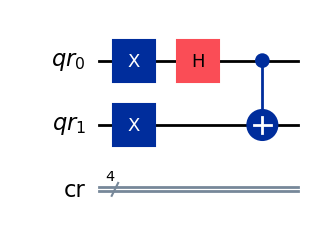

In [4]:
singlet = QuantumCircuit(qr, cr, name='singlet')
singlet.x(qr[0])
singlet.x(qr[1])
singlet.h(qr[0])
singlet.cx(qr[0],qr[1])

singlet.draw('mpl')

### Measurement Circuits

\begin{align*}
b_i = 1: \quad \vec{a}_1 = (1, 0, 0) \quad (X\text{ observable}) \qquad &
b_i = 2: \quad \vec{a}_2 = (0, 0, 1) \quad (Z\text{ observable})
\\
b_j' = 1: \quad \vec{b}_1 = (1, 0, 0) \quad (X\text{ observable}) \qquad &
b_j' = 2: \quad \vec{b}_2 = (0, 0, 1) \quad (Z\text{ observable})
\\
\end{align*}


In [5]:
## Alice's measurement circuits

# measure the spin projection of Alice's qubit onto the a_1 direction (X basis)
measureA1 = QuantumCircuit(qr, cr, name='measureA1')
measureA1.h(qr[0])
measureA1.measure(qr[0],cr[0])

# measure the spin projection of Alice's qubit onto the a_2 direction (standard Z basis)
measureA2 = QuantumCircuit(qr, cr, name='measureA2')
measureA2.measure(qr[0],cr[0])

## Bob's measurement circuits

# Key Generation Bases

# measure the spin projection of Bob's qubit onto the b_1 direction (X basis)
measureB1 = QuantumCircuit(qr, cr, name='measureB1')
measureB1.h(qr[1])
measureB1.measure(qr[1],cr[1])

# measure the spin projection of Bob's qubit onto the b_2 direction (standard Z basis)
measureB2 = QuantumCircuit(qr, cr, name='measureB2')
measureB2.measure(qr[1],cr[1])

## Lists of measurement circuits
aliceMeasurements = [measureA1, measureA2]
bobMeasurements = [measureB1, measureB2]

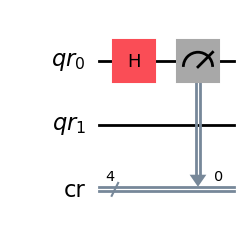

In [6]:
measureA1.draw('mpl')

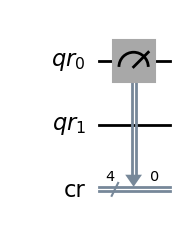

In [7]:
measureA2.draw('mpl')

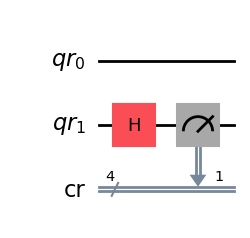

In [8]:
measureB1.draw('mpl')

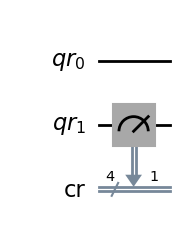

In [9]:
measureB2.draw('mpl')

### QBER Calculation

In [10]:
# QBER Part needs to be added here
def calculate_qber(aliceKey, bobKey, disclose = 10):
    if (len(aliceKey) != len(bobKey)):
        return -1
    key_length = len(aliceKey)
    num_disclosed = max(1, int(np.floor((key_length * disclose/100))))
    disclosed_indices = random.sample(range(key_length), num_disclosed)
    numKeyMismatches = 0
    for i in disclosed_indices:
        if (aliceKey[i] != bobKey[i]):
            numKeyMismatches += 1
    return (numKeyMismatches/num_disclosed) * 100

In [11]:
def bbm92_without_eavesdropping(numberOfSinglets = 5500, disclose_rate = 11, log = False):
    # Defining Measurement Choices:
    if (log):
        print("Defining Measurement Choices...")
    aliceMeasurementChoices = [random.randint(1, 2) for i in range(numberOfSinglets)] # string b of Alice
    bobMeasurementChoices = [random.randint(1, 2) for i in range(numberOfSinglets)] # string b' of Bob
    if (log):
        print("Defining Circuits and Applying Measurement Circuits as per the choices...")
    # Circuits
    circuits = []

    for i in range(numberOfSinglets):
        circuitName = f"Singlet{i}: A{aliceMeasurementChoices[i]}_B{bobMeasurementChoices[i]}"
        singletCircuit = singlet.copy()

        # Retrieve Alice's and Bob's measurement circuits
        aliceCircuitMeasurement = aliceMeasurements[aliceMeasurementChoices[i] - 1]
        bobCircuitMeasurement = bobMeasurements[bobMeasurementChoices[i] - 1]

        singletCircuit.barrier()

        # Combine the circuits (assuming sequential composition)
        singletCircuit = singletCircuit.compose(aliceCircuitMeasurement)
        singletCircuit.barrier()
        singletCircuit = singletCircuit.compose(bobCircuitMeasurement)
        singletCircuit.name = circuitName

        # Add the circuit to the list
        circuits.append(singletCircuit)

    if (log):
        print("Measuring Circuits using a backend simulator...")

    backend = AerSimulator()
    job = backend.run(circuits, shots = 1)
    results = job.result()

    abPatterns = [
        re.compile('..00$'), # search for the '..00' output (Alice obtained -1 and Bob obtained -1)
        re.compile('..01$'), # search for the '..01' output (Alice obtained 1 and Bob obtained -1)
        re.compile('..10$'), # search for the '..10' output (Alice obtained -1 and Bob obtained 1)
        re.compile('..11$')  # search for the '..11' output (Alice obtained 1 and Bob obtained 1)
    ]

    if (log):
        print("Analysing Results...")

    aliceResults = []
    bobResults = []

    for i in range(numberOfSinglets):

        res = list(results.get_counts(circuits[i]).keys())[0] # extract the key from the dict and transform it to str; execution result of the i-th circuit

        if abPatterns[0].search(res): # check if the key is '..00' (if the measurement results are -1,-1)
            aliceResults.append(-1) # Alice got the result -1
            bobResults.append(-1) # Bob got the result -1
        if abPatterns[1].search(res):
            aliceResults.append(1)
            bobResults.append(-1)
        if abPatterns[2].search(res): # check if the key is '..10' (if the measurement results are -1,1)
            aliceResults.append(-1) # Alice got the result -1
            bobResults.append(1) # Bob got the result 1
        if abPatterns[3].search(res):
            aliceResults.append(1)
            bobResults.append(1)

    if (log):
        print("Generating the key...")

    aliceKey = []
    bobKey = []

    # comparing the stings with measurement choices
    for i in range(numberOfSinglets):
        if (aliceMeasurementChoices[i] == 1 and bobMeasurementChoices[i] == 1) or (aliceMeasurementChoices[i] == 2 and bobMeasurementChoices[i] == 2):
            aliceKey.append(aliceResults[i]) # record the i-th result obtained by Alice as the bit of the secret key k
            bobKey.append(-bobResults[i]) # record the multiplied by -1 i-th result obtained Bob as the bit of the secret key k'

    keyLength = len(aliceKey) # length of the secret key

    abKeyMismatches = 0 # number of mismatching bits in Alice's and Bob's keys

    for j in range(keyLength):
        if aliceKey[j] != bobKey[j]:
            abKeyMismatches += 1

    if (log):
        print("Calculating QBER...")

    error_rate = calculate_qber(aliceKey, bobKey)

    if (log):
        print("---------------------")
        print("Protocol Summary: ")
        # Keys
        print(f"Total Number of Qubits Exchanged: " + str(numberOfSinglets))
        print(f"Alice's Key: {aliceKey}")
        print(f"Bob's key: {bobKey}")
        print(f"QBER with disclose rate {disclose_rate}%: {error_rate}")
        print('Length of the key: ' + str(keyLength))
        print('Number of mismatching bits: ' + str(abKeyMismatches) + '\n')

    return keyLength, error_rate

In [12]:
result = bbm92_without_eavesdropping(log=True)

Defining Measurement Choices...
Defining Circuits and Applying Measurement Circuits as per the choices...
Measuring Circuits using a backend simulator...
Analysing Results...
Generating the key...
Calculating QBER...
---------------------
Protocol Summary: 
Total Number of Qubits Exchanged: 5500
Alice's Key: [-1, 1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 1, 1, -1, 1, 1, -1, -1, 1, 1, 1, -1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, -1, -1, -1, -1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, 1, 1, 1, -1, -1, 1, -1, -1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, -1, -1, -1, -1, 1, 1, -1, 1, -1, 1, 1, -1, -1, -1, -1, -1, -1, 1, -1, -1, 1, 1, 1, 1, 1, 1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, 1, 1, 1, -1, -1, -1, -1, 1, -1, 1, 1, -1, 1, 1, -1, -1, 1

## Simulation of eavesdropping

### Measurement Circuits

In [13]:
# measurement of the spin projection of Alice's qubit onto the a_1 direction (X basis)
measureEA1 = QuantumCircuit(qr, cr, name='measureEA1')
measureEA1.h(qr[0])
measureEA1.measure(qr[0],cr[2])

# measurement of the spin projection of Alice's qubit onto the a_2 direction (standard Z basis)
measureEA2 = QuantumCircuit(qr, cr, name='measureEA3')
measureEA2.measure(qr[0],cr[2])

# measurement of the spin projection of Bob's qubit onto the b_1 direction (X basis)
measureEB1 = QuantumCircuit(qr, cr, name='measureEB1')
measureEB1.h(qr[1])
measureEB1.measure(qr[1],cr[3])

# measurement of the spin projection of Bob's qubit onto the b_2 direction (standard Z basis)
measureEB2 = QuantumCircuit(qr, cr, name='measureEB2')
measureEB2.measure(qr[1],cr[3])

# lists of measurement circuits
eveMeasurements = [measureEA1, measureEA2, measureEB1, measureEB2]

In [14]:
def bbm92_with_eavesdropping(numberOfSinglets = 5500, disclose_rate = 11, qber_threshold = 0.11, log = False):
    # Defining Measurement Choices:
    if (log):
        print("Defining Measurement Choices...")

    aliceMeasurementChoices = [random.randint(1, 2) for i in range(numberOfSinglets)] # string b of Alice
    bobMeasurementChoices = [random.randint(1, 2) for i in range(numberOfSinglets)] # string b' of Bob

    if (log):
        print("Defining Circuits and Applying Measurement Circuits as per the choices...")

    # Circuits
    ABECircuits = []
    attack_probability = 4 * qber_threshold
    num_intercepts = 0
    intercepted_qubit_indices = []

    for j in range(numberOfSinglets):
        eveMeasurementChoices = []
        SingletCircuitABE = singlet.copy()
        eve_intercepts = np.random.rand() < attack_probability
        if (eve_intercepts):
            num_intercepts += 1
            intercepted_qubit_indices.append(j)
            if random.uniform(0, 1) <= 0.5: # in 50% of cases perform the XX measurement
                eveMeasurementChoices.append([0, 2])
            else:
                eveMeasurementChoices.append([1, 3])
            SingletCircuitABE.barrier()
            SingletCircuitABE = SingletCircuitABE.compose(eveMeasurements[eveMeasurementChoices[0][0]])
            SingletCircuitABE.barrier()
            SingletCircuitABE = SingletCircuitABE.compose(eveMeasurements[eveMeasurementChoices[0][1]])
            SingletCircuitABE.barrier()
            circuitName = f"SingletABE{j}:A{aliceMeasurementChoices[j]}_B{bobMeasurementChoices[j]}_E{eveMeasurementChoices[0][0]}{eveMeasurementChoices[0][1]}"
        else:
            circuitName = f"SingletABE{j}:A{aliceMeasurementChoices[j]}_B{bobMeasurementChoices[j]}_NoEavesdropping"

        SingletCircuitABE = SingletCircuitABE.compose(aliceMeasurements[aliceMeasurementChoices[j] - 1])
        SingletCircuitABE.barrier()
        SingletCircuitABE = SingletCircuitABE.compose(bobMeasurements[bobMeasurementChoices[j] - 1])

        SingletCircuitABE.name = circuitName
        # add the created circuit to the circuits list
        ABECircuits.append(SingletCircuitABE)

    if (log):
        print("Measuring Circuits using a backend simulator...")

    backend = AerSimulator()
    Eavesdropping_results = backend.run(ABECircuits, shots = 1).result()

    ePatterns = [
        re.compile('00..$'), # search for the '00..' result (Eve obtained the results -1 and -1 for Alice's and Bob's qubits)
        re.compile('01..$'), # search for the '01..' result (Eve obtained the results 1 and -1 for Alice's and Bob's qubits)
        re.compile('10..$'), # search for the '10..' result (Eve obtained the results -1 and 1 for Alice's and Bob's qubits)
        re.compile('11..$')  # search for the '11..' result (Eve obtained the results 1 and 1 for Alice's and Bob's qubits)
    ]

    abPatterns = [
        re.compile('..00$'), # search for the '..00' output (Alice obtained -1 and Bob obtained -1)
        re.compile('..01$'), # search for the '..01' output (Alice obtained 1 and Bob obtained -1)
        re.compile('..10$'), # search for the '..10' output (Alice obtained -1 and Bob obtained 1)
        re.compile('..11$')  # search for the '..11' output (Alice obtained 1 and Bob obtained 1)
    ]

    if (log):
        print("Analysing Results...")

    aliceResults = []
    bobResults = []
    eveResults = []

    for j in range(numberOfSinglets):
        res = list(Eavesdropping_results.get_counts(ABECircuits[j]).keys())[0] # extract a key from the dict and transform it to str
        # Alice and Bob
        if abPatterns[0].search(res): # check if the key is '..00' (if the measurement results are -1,-1)
            aliceResults.append(-1) # Alice got the result -1
            bobResults.append(-1) # Bob got the result -1
        if abPatterns[1].search(res): # check if the key is '..01' (if the measurement results are 1,-1)
            aliceResults.append(1)
            bobResults.append(-1)
        if abPatterns[2].search(res): # check if the key is '..10' (if the measurement results are -1,1)
            aliceResults.append(-1) # Alice got the result -1
            bobResults.append(1) # Bob got the result 1
        if abPatterns[3].search(res): # check if the key is '..11' (if the measurement results are 1,1)
            aliceResults.append(1)
            bobResults.append(1)

        # Eve
        if ePatterns[0].search(res): # check if the key is '00..'
            eveResults.append([-1, -1]) # results of the measurement of Alice's and Bob's qubits are -1,-1
        if ePatterns[1].search(res): # check if the key is '01..'
            eveResults.append([1, -1]) # results of the measurement of Alice's and Bob's qubits are 1,-1
        if ePatterns[2].search(res): # check if the key is '10..'
            eveResults.append([-1, 1]) # results of the measurement of Alice's and Bob's qubits are -1,1
        if ePatterns[3].search(res): # check if the key is '11..'
            eveResults.append([1, 1]) # results of the measurement of Alice's and Bob's qubits are 1,1

    if (log):
        print("Generating the key...")

    aliceKey = [] # Alice's key string a
    bobKey = [] # Bob's key string a'
    eveKeys = [] # Eve's keys; the 1-st column is the key of Alice, and the 2-nd is the key of Bob

    keyIndices = [] # Indices of Qubits used for the key
    key_index_with_intercepted_qubit = [] # Indices of Alice's and Bob's Key which was formed using the qubits that was intercepted by Eve
    idx = 0
    # comparing the strings with measurement choices (b and b')
    for j in range(numberOfSinglets):
        # if Alice and Bob measured the spin projections onto the a_2/b_1 or a_3/b_2 directions
        if (aliceMeasurementChoices[j] == 1 and bobMeasurementChoices[j] == 1) or (aliceMeasurementChoices[j] == 2 and bobMeasurementChoices[j] == 2):
            keyIndices.append(j)
            if j in intercepted_qubit_indices:
                key_index_with_intercepted_qubit.append(idx)
                eveKeys.append([eveResults[j][0], -eveResults[j][1]]) # record the i-th bits of the keys of Eve
            aliceKey.append(aliceResults[j]) # record the i-th result obtained by Alice as the bit of the secret key k
            bobKey.append(-bobResults[j]) # record the multiplied by -1 i-th result obtained Bob as the bit of the secret key k'
            idx += 1

    keyLength = len(aliceKey) # length of the secret key

    if (log):
        print("Calculating Key Mismatches...")

    abKeyMismatches = 0 # number of mismatching bits in the keys of Alice and Bob
    eaKeyMismatches = 0 # number of mismatching bits in the keys of Eve and Alice
    ebKeyMismatches = 0 # number of mismatching bits in the keys of Eve and Bob

    for j in range(keyLength):
        if aliceKey[j] != bobKey[j]:
            abKeyMismatches += 1

    for j in range(len(key_index_with_intercepted_qubit)):
        if eveKeys[j][0] != aliceKey[key_index_with_intercepted_qubit[j]]:
            eaKeyMismatches += 1
        if eveKeys[j][1] != bobKey[key_index_with_intercepted_qubit[j]]:
            ebKeyMismatches += 1

    num_intercepts_used_in_key = len(key_index_with_intercepted_qubit);

    if (log):
        print("Calculating Eve's Knowledge of Alice's and Bob's Keys...")
    eaKnowledge = (num_intercepts_used_in_key - eaKeyMismatches)/num_intercepts_used_in_key # Eve's knowledge of Alice's key
    ebKnowledge = (num_intercepts_used_in_key - ebKeyMismatches)/num_intercepts_used_in_key # Eve's knowledge of Bob's key

    if (log):
        print("Calculating QBER...")
    error_rate = calculate_qber(aliceKey, bobKey)

    if (log):
        print("---------------------")
        print("Protocol Summary: ")
        print("Number of Qubits: " + str(numberOfSinglets))
        # Keys
        print('Length of the key: ' + str(keyLength))
        print('Number of mismatching bits: ' + str(abKeyMismatches))
        print(f"QBER with disclose rate of {disclose_rate}%: {error_rate}" + '\n')

        print('Number of qubits intercepted: ' + str(num_intercepts))
        print('Number of intercepted qubits used in the key: ' + str(num_intercepts_used_in_key) + "\n")

        print('Eve Alice Key mismatches: ' + str(eaKeyMismatches))
        print('Eve Bob Key mismatches: ' + str(ebKeyMismatches) + '\n')

        print('Eve\'s knowledge of Alice\'s key: ' + str(round(eaKnowledge * 100, 2)) + ' %')
        print('Eve\'s knowledge of Bob\'s key: ' + str(round(ebKnowledge * 100, 2)) + ' %')

    return keyLength, error_rate, eaKnowledge, ebKnowledge


In [15]:
result = bbm92_with_eavesdropping(numberOfSinglets=5500, log=True)

Defining Measurement Choices...
Defining Circuits and Applying Measurement Circuits as per the choices...
Measuring Circuits using a backend simulator...
Analysing Results...
Generating the key...
Calculating Key Mismatches...
Calculating Eve's Knowledge of Alice's and Bob's Keys...
Calculating QBER...
---------------------
Protocol Summary: 
Number of Qubits: 5500
Length of the key: 2784
Number of mismatching bits: 320
QBER with disclose rate of 11%: 11.510791366906476

Number of qubits intercepted: 2404
Number of intercepted qubits used in the key: 1220

Eve Alice Key mismatches: 326
Eve Bob Key mismatches: 316

Eve's knowledge of Alice's key: 73.28 %
Eve's knowledge of Bob's key: 74.1 %


# Graphs

### QBER Threshold v/s Eve's Knowledge of Alice's Key, Eve's Knowledge of Bob's Key

In [ ]:
number_of_qubits = 5500
values = np.linspace(0.05, 0.20, 16)
qber_threshold_values = np.round(values, 2).tolist()
eve_alice_knowledge = []
eve_bob_knowledge = []
for i in range(len(qber_threshold_values)):
    ea_outputs = []
    eb_outputs = []
    for _ in range(30):
        result = bbm92_with_eavesdropping(numberOfSinglets=number_of_qubits, qber_threshold=qber_threshold_values[i])
        ea_val = result[3]
        eb_val = result[4]
        ea_outputs.append(ea_val)
        eb_outputs.append(eb_val)
    eve_alice_knowledge.append(sum(ea_outputs)/len(ea_outputs))
    eve_bob_knowledge.append(sum(eb_outputs)/len(eb_outputs))
    print(f"Circuit {i} done")

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(qber_threshold_values, eve_alice_knowledge, marker='o', label='Eve-Alice', color='blue')
plt.plot(qber_threshold_values, eve_bob_knowledge, marker='o', label='Eve-Bob', color='orange')
plt.title('QBER Threshold v/s Eve\'s Knowledge of Alice\'s and Bob\'s Key')
plt.xlabel('QBER Threshold')
plt.ylabel('Eve\'s Knowledge (Percentage)')
plt.legend()
plt.grid(True)
plt.show()

### On an average, how many times is the QBER Threshold is Violated during an Eavesdropping (30 Eavesdropping Simulations for each QBER Threshold)

In [ ]:
number_of_qubits = 5500
values = np.linspace(0.05, 0.20, 16)
qber_threshold_values = np.round(values, 2).tolist()
qber_violations = []
for i in range(len(qber_threshold_values)):
    cnt = 0
    for _ in range(30):
        error_rate = bbm92_with_eavesdropping(numberOfSinglets=number_of_qubits, qber_threshold=qber_threshold_values[i])[1]
        if error_rate > qber_threshold_values[i]:
            cnt += 1
    qber_violations.append(cnt)
    print(f"Circuit {i} done")

In [ ]:
plt.bar(qber_threshold_values, qber_violations, color="skyblue")
plt.title("Number of QBER Violations (Out of 30 Simulations)")
plt.xlabel("QBER Threshold")
plt.ylabel("Counts")
plt.grid(True)
plt.show()